In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
import tensorflow as tf
import timeit

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/cpu:0'):
  random_image_cpu = tf.random_normal((100, 100, 100, 3))
  net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)
  net_cpu = tf.reduce_sum(net_cpu)

with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)

sess = tf.Session(config=config)

# Test execution once to detect errors early.
try:
  sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

def cpu():
  sess.run(net_cpu)
  
def gpu():
  sess.run(net_gpu)
  
# Runs the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

sess.close()

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
10.672368905999974
GPU (s):
0.49130884500027605
GPU speedup over CPU: 21x


In [0]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive"

CNN Street Images
Colab Notebooks
DATA SCIENCE AND MACHINE LEARNING BOOTCAMP WITH R BY JOSE PORTILLA
Marvel.mp4
what if crystal.swf


In [0]:
!pip install Cython

In [0]:
!git clone https://github.com/waleedka/coco

Cloning into 'coco'...
remote: Enumerating objects: 904, done.
remote: Total 904 (delta 0), reused 0 (delta 0), pack-reused 904
Receiving objects: 100% (904/904), 10.39 MiB | 12.03 MiB/s, done.
Resolving deltas: 100% (541/541), done.


In [0]:
!pip install -U setuptools
!pip install -U wheel
!make install -C coco/PythonAPI

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (40.4.3)
Requirement already up-to-date: wheel in /usr/local/lib/python3.6/dist-packages (0.32.1)
make: Entering directory '/content/Mask_RCNN/coco/PythonAPI'
# install pycocotools to the Python site-packages
python setup.py build_ext install
Compiling pycocotools/_mask.pyx because it changed.
[1/1] Cythonizing pycocotools/_mask.pyx
running build_ext
building 'pycocotools._mask' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
creating build/common
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -Wstrict-prototypes -g -fdebug-prefix-map=/build/python3.6-sXpGnM/python3.6-3.6.3=. -specs=/usr/share/dpkg/no-pie-compile.specs -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/usr/include/python3.6m -c pycocotools/_ma

In [0]:
!git clone https://github.com/matterport/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Counting objects: 893, done.
remote: Total 893 (delta 0), reused 0 (delta 0), pack-reused 892
Receiving objects: 100% (893/893), 113.09 MiB | 24.12 MiB/s, done.
Resolving deltas: 100% (525/525), done.


In [0]:
import os
os.chdir('./Mask_RCNN')
!git checkout 555126ee899a144ceff09e90b5b2cf46c321200c
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

Note: checking out '555126ee899a144ceff09e90b5b2cf46c321200c'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 555126e... Balloon Color Splash sample.

Redirecting output to ‘wget-log’.


In [0]:
!ls

assets	    inspect_data.ipynb	   model.py	      train_shapes.ipynb
coco.py     inspect_model.ipynb    parallel_model.py  utils.py
config.py   inspect_weights.ipynb  README.md	      visualize.py
demo.ipynb  LICENSE		   samples	      wget-log
images	    mask_rcnn_coco.h5	   shapes.py


In [0]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import coco
import utils
import model as modellib
import visualize

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

In [0]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENC

In [0]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [0]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

Processing 1 images
image                    shape: (334, 500, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


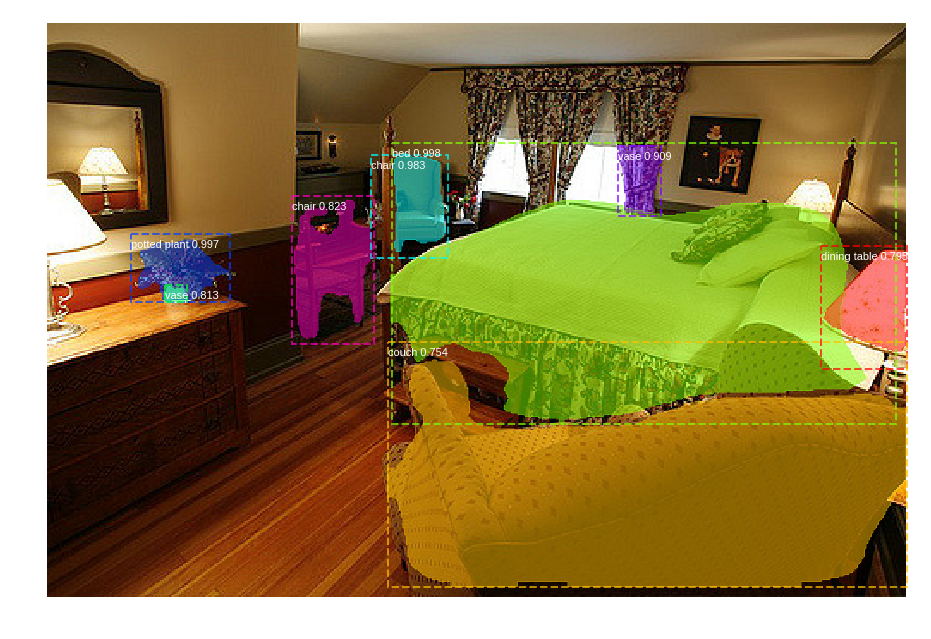

In [0]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [0]:
!mkdir videos
!wget https://github.com/afzal-joy/MASK-CNN/releases/download/v1.0/Street.mp4 -P ./videos


Redirecting output to ‘wget-log.1’.


In [0]:
!ls ./videos

ls: cannot access './videos': No such file or directory


In [0]:
import cv2
import numpy as np


def random_colors(N):
    np.random.seed(1)
    colors = [tuple(255 * np.random.rand(3)) for _ in range(N)]
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """apply mask to image"""
    for n, c in enumerate(color):
        image[:, :, n] = np.where(
            mask == 1,
            image[:, :, n] * (1 - alpha) + alpha * c,
            image[:, :, n]
        )
    return image


def display_instances(image, boxes, masks, ids, names, scores):
    """
        take the image and results and apply the mask, box, and Label
    """
    n_instances = boxes.shape[0]
    colors = random_colors(n_instances)

    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i, color in enumerate(colors):
        if not np.any(boxes[i]):
            continue

        y1, x1, y2, x2 = boxes[i]
        label = names[ids[i]]
        score = scores[i] if scores is not None else None
        caption = '{} {:.2f}'.format(label, score) if score else label
        mask = masks[:, :, i]

        image = apply_mask(image, mask, color)
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        image = cv2.putText(
            image, caption, (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.7, color, 2
        )

    return image


if __name__ == '__main__':
    """
        test everything
    """
    import os
    import sys
    import coco
    import utils
    import model as modellib
    
    # We use a K80 GPU with 24GB memory, which can fit 3 images.
    batch_size = 3
    
    ROOT_DIR = os.getcwd()
    MODEL_DIR = os.path.join(ROOT_DIR, "logs")
    VIDEO_DIR = os.path.join(ROOT_DIR, "videos")
    
    VIDEO_SAVE_DIR = os.path.join(VIDEO_DIR, "Save")
    COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
    if not os.path.exists(COCO_MODEL_PATH):
        utils.download_trained_weights(COCO_MODEL_PATH)

    class InferenceConfig(coco.CocoConfig):
        GPU_COUNT = 1
        IMAGES_PER_GPU = batch_size

    config = InferenceConfig()
    config.display()

    model = modellib.MaskRCNN(
        mode="inference", model_dir=MODEL_DIR, config=config
    )
    model.load_weights(COCO_MODEL_PATH, by_name=True)
    class_names = [
        'BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
        'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
        'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
        'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
        'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
        'kite', 'baseball bat', 'baseball glove', 'skateboard',
        'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
        'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
        'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
        'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
        'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
        'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
        'teddy bear', 'hair drier', 'toothbrush'
    ]

    capture = cv2.VideoCapture(os.path.join(VIDEO_DIR, 'Street.mp4'))
    try:
        if not os.path.exists(VIDEO_SAVE_DIR):
            os.makedirs(VIDEO_SAVE_DIR)
    except OSError:
        print ('Error: Creating directory of data')
    frames = []
    frame_count = 0
    # these 2 lines can be removed if you dont have a 1080p camera.
    capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
    capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

    while True:
        ret, frame = capture.read()
        # Bail out when the video file ends
        if not ret:
            break
        
        # Save each frame of the video to a list
        frame_count += 1
        frames.append(frame)
        print('frame_count :{0}'.format(frame_count))
        if len(frames) == batch_size:
            results = model.detect(frames, verbose=0)
            print('Predicted')
            for i, item in enumerate(zip(frames, results)):
                frame = item[0]
                r = item[1]
                frame = display_instances(
                    frame, r['rois'], r['masks'], r['class_ids'], class_names, r['scores']
                )
                name = '{0}.jpg'.format(frame_count + i - batch_size)
                name = os.path.join(VIDEO_SAVE_DIR, name)
                cv2.imwrite(name, frame)
                print('writing to file:{0}'.format(name))
            # Clear the frames array to start the next batch
            frames = []

    capture.release()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     3
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 3
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENC

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Predicted
writing to file:/content/Mask_RCNN/videos/Save/0.jpg
writing to file:/content/Mask_RCNN/videos/Save/1.jpg
writing to file:/content/Mask_RCNN/videos/Save/2.jpg
frame_count :4
frame_count :5
frame_count :6
Predicted
writing to file:/content/Mask_RCNN/videos/Save/3.jpg
writing to file:/content/Mask_RCNN/videos/Save/4.jpg
writing to file:/content/Mask_RCNN/videos/Save/5.jpg
frame_count :7
frame_count :8
frame_count :9
Predicted
writing to file:/content/Mask_RCNN/videos/Save/6.jpg
writing to file:/content/Mask_RCNN/videos/Save/7.jpg
writing to file:/content/Mask_RCNN/videos/Save/8.jpg
frame_count :10
frame_count :11
frame_count :12
Predicted
writing to file:/content/Mask_RCNN/videos/Save/9.jpg
writing to file:/content/Mask_RCNN/videos/Save/10.jpg
writing to file:/content/Mask_RCNN/videos/Save/11.jpg
frame_count :13
frame_count :14
frame_count :15
Predicted
writing to file:/content/Mask_RCNN/videos/Save/12.jpg
writing to file:/content/Mask_RCNN/videos/Save/13.jpg
writing to file:/c

In [0]:
!ls ./videos/Save

0.jpg	 176.jpg  251.jpg  327.jpg  402.jpg  479.jpg  554.jpg  62.jpg	705.jpg
100.jpg  177.jpg  252.jpg  328.jpg  403.jpg  47.jpg   555.jpg  630.jpg	706.jpg
101.jpg  178.jpg  253.jpg  329.jpg  404.jpg  480.jpg  556.jpg  631.jpg	707.jpg
102.jpg  179.jpg  254.jpg  32.jpg   405.jpg  481.jpg  557.jpg  632.jpg	708.jpg
103.jpg  17.jpg   255.jpg  330.jpg  406.jpg  482.jpg  558.jpg  633.jpg	709.jpg
104.jpg  180.jpg  256.jpg  331.jpg  407.jpg  483.jpg  559.jpg  634.jpg	70.jpg
105.jpg  181.jpg  257.jpg  332.jpg  408.jpg  484.jpg  55.jpg   635.jpg	710.jpg
106.jpg  182.jpg  258.jpg  333.jpg  409.jpg  485.jpg  560.jpg  636.jpg	711.jpg
107.jpg  183.jpg  259.jpg  334.jpg  40.jpg   486.jpg  561.jpg  637.jpg	712.jpg
108.jpg  184.jpg  25.jpg   335.jpg  410.jpg  487.jpg  562.jpg  638.jpg	713.jpg
109.jpg  185.jpg  260.jpg  336.jpg  411.jpg  488.jpg  563.jpg  639.jpg	714.jpg
10.jpg	 186.jpg  261.jpg  337.jpg  412.jpg  489.jpg  564.jpg  63.jpg	715.jpg
110.jpg  187.jpg  262.jpg  338.jpg  413.jpg  48.jpg   565.

In [0]:
video = cv2.VideoCapture(os.path.join(VIDEO_DIR, 'Street.mp4'));

# Find OpenCV version
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

if int(major_ver)  < 3 :
    fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
else :
    fps = video.get(cv2.CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))

video.release();

Frames per second using video.get(cv2.CAP_PROP_FPS) : 25.0


In [0]:
def make_video(outvid, images=None, fps=25, size=None,
               is_color=True, format="FMP4"):
    """
    Create a video from a list of images.
 
    @param      outvid      output video
    @param      images      list of images to use in the video
    @param      fps         frame per second
    @param      size        size of each frame
    @param      is_color    color
    @param      format      see http://www.fourcc.org/codecs.php
    @return                 see http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
 
    The function relies on http://opencv-python-tutroals.readthedocs.org/en/latest/.
    By default, the video will have the size of the first image.
    It will resize every image to this size before adding them to the video.
    """
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if not os.path.exists(image):
            raise FileNotFoundError(image)
        img = imread(image)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid

import glob
import os

# Directory of images to run detection on
ROOT_DIR = os.getcwd()
DRIVE_DIR  = '/content'

VIDEO_DIR = os.path.join(ROOT_DIR, "videos")
DRIVE_DIR_CNN = os.path.join(DRIVE_DIR, "drive/CNN Street Images")
VIDEO_SAVE_DIR = os.path.join(VIDEO_DIR, "Save")


images = list(glob.iglob(os.path.join(VIDEO_SAVE_DIR, '*.*')))
# Sort the images by integer index
images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))

outvid = os.path.join(DRIVE_DIR_CNN, "streetcnnoutput.mp4")
make_video(outvid, images, fps=25)

<VideoWriter 0x7f750a288790>

In [0]:
!ls -alh ./videos/

total 131M
drwxr-xr-x 3 root root 4.0K Oct  6 09:17 .
drwxr-xr-x 8 root root 4.0K Oct  6 08:36 ..
drwxr-xr-x 2 root root  20K Oct  6 09:17 Save
-rw-r--r-- 1 root root 121M Oct  6 09:18 streetcnnoutput.mp4
-rw-r--r-- 1 root root  11M Oct  2 14:59 Street.mp4


In [0]:
from google.colab import files
files.download('videos/streetcnnoutput.mp4')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 40494, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 696, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [0]:

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:


# Create & upload a file.
uploaded = drive.CreateFile({'title': 'drive/My Drive/CNN Street Images/ccc.mp4'})
uploaded.SetContentFile('Mask_RCNN/videos/streetcnnoutput.mp4')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1Dw8va-ci9XC9Gw4VzFlW-kEGcmS1lmHv


In [0]:
import os
os.getcwd()


'/content'

In [0]:
os.chdir('/content/')